In [29]:
import qmcpy as qp
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import cProfile
import pstats

In [30]:
def natural(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,thread=False)
    points = l.gen_samples(num_ports) 
    return points
def linear(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,thread=False)
    points = l.gen_samples(num_ports) 
    return points
def mps(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,thread=False)
    points = l.gen_samples(num_ports) 
    return points
def natural_thread(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,thread=True)
    points = l.gen_samples(num_ports) 
    return points
def linear_thread(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,thread=True)
    points = l.gen_samples(num_ports) 
    return points
def mps_thread(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,thread=True)
    points = l.gen_samples(num_ports) 
    return points


In [31]:
trials = 5
d_list = [50, 100, 200, 500, 1400, 3500]
n = 10
data = {'index':d_list}
frame = pd.DataFrame(data)
frame = frame.set_index('index')
names = set()


run_list = [(natural, "natural"),(linear, "linear"),(mps,"mps"),(natural_thread, "natural thread"),(linear_thread,"linear thread"),(mps_thread, "mps thread")]

for method,method_name in run_list:

    name = method_name.split(" ")

    names.add(name[0])

    times = []
    
    for d in d_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, 2 ** n)
        profiler.disable()
        
        stats = pstats.Stats(profiler)
            
        process_time = stats.total_tt

        times.append(process_time)
        
    frame[method_name] = times  
stats.sort_stats('cumulative')


names = list(names)  

print(frame)
 


        natural    linear       mps  natural thread  linear thread  mps thread
index                                                                         
50     0.027800  0.015832  0.018510        0.030588       0.016397    0.060474
100    0.040801  0.028718  0.031852        0.044109       0.029935    0.067655
200    0.082211  0.060244  0.063019        0.066165       0.061200    0.085903
500    0.157974  0.145721  0.154894        0.133638       0.146770    0.141491
1400   0.418609  0.403971  0.434229        0.335088       0.403437    0.353891
3500   1.031641  1.006340  1.082820        0.801679       1.001819    0.741560


In [32]:
comparse= [('mps','mps thread'),('linear', 'linear thread'),('natural', 'natural thread')]



def speed_up_cal(data_frame, compare_list, dimension_list):
    result = []
    for seq,pro in compare_list:
        result = []
        for x in dimension_list:
            a = data_frame[seq][x]
            b = data_frame[pro][x]
            result.append(a/b)
        data_frame[seq + " speed-up"] = result


speed_up_cal(frame, comparse, d_list)

print(frame)




        natural    linear       mps  natural thread  linear thread  \
index                                                                
50     0.027800  0.015832  0.018510        0.030588       0.016397   
100    0.040801  0.028718  0.031852        0.044109       0.029935   
200    0.082211  0.060244  0.063019        0.066165       0.061200   
500    0.157974  0.145721  0.154894        0.133638       0.146770   
1400   0.418609  0.403971  0.434229        0.335088       0.403437   
3500   1.031641  1.006340  1.082820        0.801679       1.001819   

       mps thread  mps speed-up  linear speed-up  natural speed-up  
index                                                               
50       0.060474      0.306074         0.965518          0.908863  
100      0.067655      0.470806         0.959325          0.924987  
200      0.085903      0.733612         0.984371          1.242509  
500      0.141491      1.094727         0.992854          1.182106  
1400     0.353891      1.

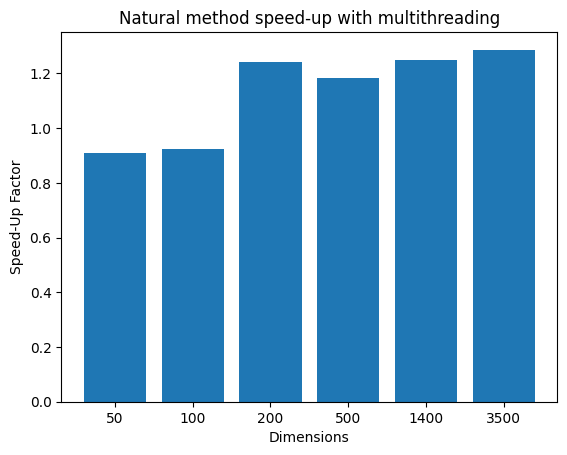

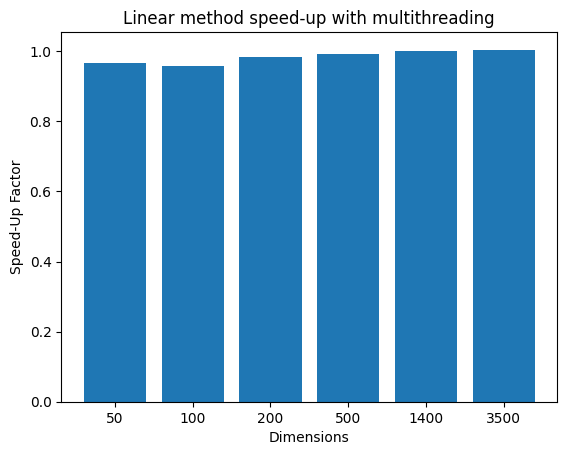

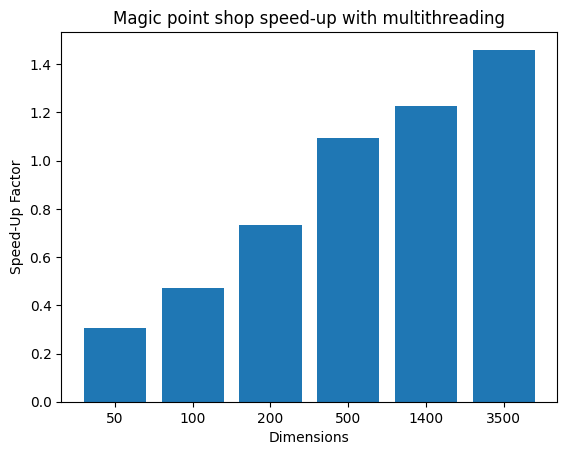

In [33]:
x = lambda array: [str(x) for x in array]

y_axis = frame["natural speed-up"].to_numpy()
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Natural method speed-up with multithreading')
plt.show()

y_axis = frame["linear speed-up"].to_numpy()
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Linear method speed-up with multithreading')
plt.show()

y_axis = frame["mps speed-up"].to_numpy()
x_axis = x(d_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Magic point shop speed-up with multithreading')
plt.show()


In [36]:
d = 10
p_list = [10, 100, 1000, 10_000, 15_000]
records = {'index':p_list}
frame2 = pd.DataFrame(records)
frame2 = frame2.set_index('index')
names = set()

for method, method_name in run_list:
    name = method_name.split(" ")

    names.add(name[0])


    times = []
    
    for p in p_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(2 ** d, p)
        profiler.disable()
    
        stats = pstats.Stats(profiler)
        
        process_time = stats.total_tt


        times.append(process_time)
    
    frame2[method_name] = times  
stats.sort_stats('cumulative')


names = list(names)     
speed_up_cal(frame2,comparse, p_list)
#print(frame2)

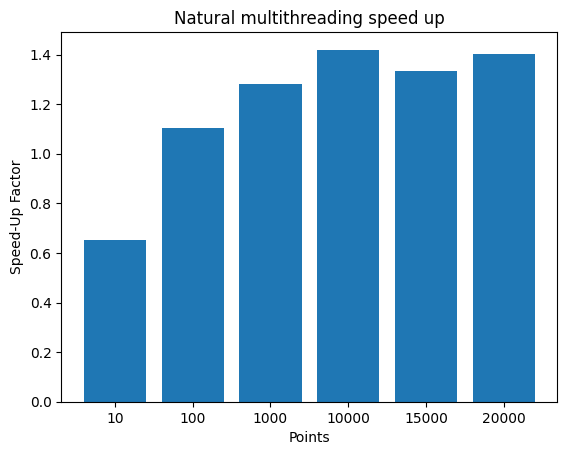

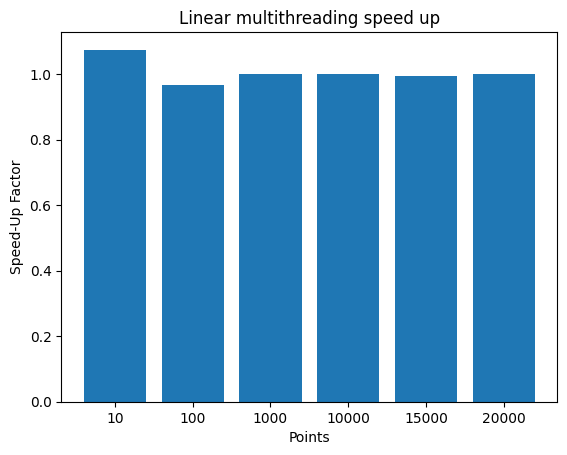

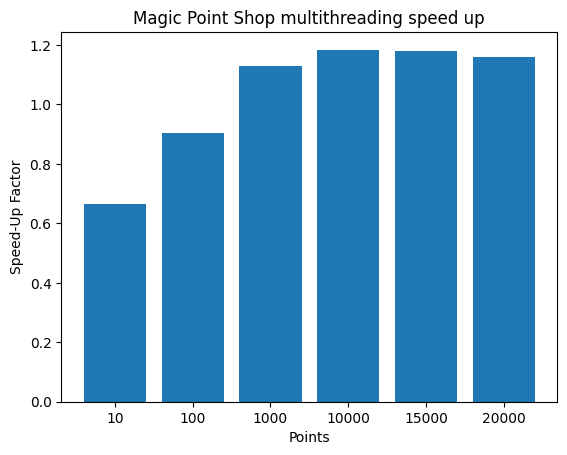

In [37]:
x = lambda array: [str(x) for x in array]

y_axis = frame2["natural speed-up"].to_numpy()
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Natural multithreading speed up')
plt.show()

y_axis = frame2["linear speed-up"].to_numpy()
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Linear multithreading speed up')
plt.show()

y_axis = frame2["mps speed-up"].to_numpy()
x_axis = x(p_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Magic Point Shop multithreading speed up')
plt.show()